In [63]:
from os import listdir
from os.path import isfile, join
import os
import numpy
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import time

import glob

#import math

#import datetime
import pandas as pd

# input image dimensions
imgSize = [129,129]
input_shape = (imgSize[0],imgSize[1],1)
numpy.random.seed(123)  # for reproducibility

def load_train(img_path):
    # open images in one letter folder
    mypath=img_path
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    print(onlyfiles)
    #.Dash_store
    if onlyfiles[0][0] == '.':  
        del onlyfiles[0]
        print(onlyfiles)
    images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
    labels = numpy.empty(len(onlyfiles), dtype=object)
    print(images.shape)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(mypath,onlyfiles[n]) )
        img = cv2.resize(img, (129, 129))
        #convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion to remove some noise
        kernel = numpy.ones((1, 1), numpy.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        img = cv2.erode(img, kernel, iterations=1)
        
        #  Apply threshold to get image with only black and white
        # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
        # threshold make the picture a little bumpy
        
        images[n] = img
        # get the font only
        # labels[n] = onlyfiles[n].split("-")[1].split(".png")[0]
        # get the font and tag
        # labels[n] = onlyfiles[n].split(".png")[0]
        labels[n] = onlyfiles[n].split(".png")[0].split("-")[1]
        # print(img.shape)
        
        if (n==0):
            plt.subplot(330 + (n+1))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(labels[n])
            plt.savefig("test.png",bbox_inches='tight')
        
    return [images,labels]

def load_train_dic(file_path):
    # open images in one letter folder
    mypath=file_path
    folders = [ f for f in listdir(mypath) ]
    print("folders:",folders)
    #.Dash_store
    if folders[0][0] == '.':  
        del folders[0]
        print("after folders:",folders)
    imagesArr = numpy.empty([1,imgSize[0],imgSize[1]], dtype=object)
    labelsArr = numpy.empty(1, dtype=object)
    print("arrshape:", imagesArr.shape)
    for i in range(0, len(folders)):
        targetpath = join(mypath,folders[i])  
        onlyfiles = [ f for f in listdir(targetpath) if isfile(join(targetpath,f)) ]
        #print("only files:",onlyfiles)
        if onlyfiles[0][0] == '.':  
            del onlyfiles[0]
            print("after",onlyfiles)
        images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
        labels = numpy.empty(len(onlyfiles), dtype=object)
        print("images.shape b:",images.shape)
        for n in range(0, len(onlyfiles)):
            img = cv2.imread( join(targetpath,onlyfiles[n]) )
            img = cv2.resize(img, (129, 129))
            #convert to gray
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply dilation and erosion to remove some noise
            kernel = numpy.ones((1, 1), numpy.uint8)
            img = cv2.dilate(img, kernel, iterations=1)
            img = cv2.erode(img, kernel, iterations=1)

            #  Apply threshold to get image with only black and white
            # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
            # threshold make the picture a little bumpy

            images[n] = img
            # get the font only
            # labels[n] = onlyfiles[n].split("-")[1].split(".png")[0]
            # get the font and tag
            labels[n] = onlyfiles[n].split(".png")[0]
            # print(img.shape)

            if (n==0):
                plt.subplot(330 + (n+1))
                plt.imshow(img, cmap=plt.get_cmap('gray'))
                plt.title(labels[n])
                plt.savefig("test.png",bbox_inches='tight')
        
        print("images a:",images.shape)
        imagesArr = numpy.append(imagesArr, images, axis = 0)
        labelsArr = numpy.append(labelsArr, labels, axis = 0)
        print(imagesArr.shape, labelsArr.shape)
        print("i:",i, targetpath)
        if i==51 :
            print("onlyfiles:",len(onlyfiles),onlyfiles)
        
    imagesArr = numpy.delete(imagesArr, 0, 0)
    labelsArr = numpy.delete(labelsArr, 0)
    print(imagesArr.shape, labelsArr.shape)
    return [imagesArr, labelsArr]

In [64]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)

def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model

def process_income_image(input_data):
    input_data = numpy.array(input_data, dtype=numpy.float32)
    # train_data = train_data.transpose((0, 3, 1, 2))
    input_data = input_data.astype('float32')
    input_data /= 255
    print('Train shape:', input_data.shape)
    print(input_data.shape[0], 'train samples')
    input_data = input_data.reshape(input_data.shape[0],input_data.shape[1],input_data.shape[2],1)
    print(input_data.shape)
    return input_data

In [65]:
cache_path = os.path.join('cache', 'train.dat')
if not os.path.isfile(cache_path):
    # train_data, train_target = load_train()
    
    X_train, y_train = load_train('preview')#load_train('onlyletter/g1')
    #X_train, y_train = load_train_dic('onlyletter/')
    # load_train('trimeddataset/g1')
    print(X_train.shape, y_train.shape)
    print(y_train)
    cache_data((X_train, y_train), cache_path)
    print("cache_data")
else:
    print('Restore train from cache!')
    (X_train, y_train) = restore_data(cache_path)
    print(X_train.shape, y_train.shape)
    

Restore train from cache!
(382, 129, 129) (382,)


In [66]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#save the uncoded labels
labels_data = y_train
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# print(encoded_Y.shape, encoded_Y) 
# [0,1,2,3...,34,35]
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
# print(dummy_y.shape, dummy_y)
# [1,0,0....0][0,1,0....,0][0,0,1,...,0]

y_train = dummy_y
print(y_train.shape)

(382, 12)


In [67]:
X_train = process_income_image(X_train)
imgTrain = X_train.reshape(X_train.shape[0], imgSize[0], imgSize[1])

Train shape: (382, 129, 129)
382 train samples
(382, 129, 129, 1)


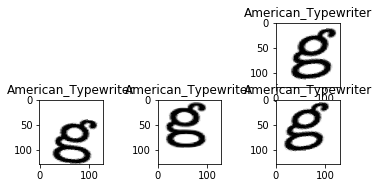

In [68]:
from sklearn.model_selection import train_test_split
from spatial_transformer import SpatialTransformer

# imgTrain2 = image_arrayts.reshape(images_datats.shape[0], imgSize[0], imgSize[1])

for i in range(5, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(imgTrain[i], cmap=plt.get_cmap('gray'))
    plt.title(labels_data[i])

In [69]:
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint

callbacks = [EarlyStopping(monitor='loss',patience=3,verbose=1)]#]#monitor='val_loss',patience=3,verbose=1)]

In [70]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def generatImage(img, label):
    datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            #zoom_range=0.2,
            zoom_range=[1.3,1.5],
            fill_mode="constant",
            cval=255
            # horizontal_flip=True,
            )

    #img = load_img('trimeddataset/g1/h1-Baskerville.png')  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    label = label + '-0'
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='preview', save_prefix=label, save_format='png'):
        i += 1
        if i > 30:
            break  # otherwise the generator would loop indefinitely

In [71]:
def loadImageToGen(img_path):    
    # open images in one letter folder
    mypath=img_path
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    print(onlyfiles)
    #.Dash_store
    if onlyfiles[0][0] == '.':  
        del onlyfiles[0]
        print(onlyfiles)
    images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
    labels = numpy.empty(len(onlyfiles), dtype=object)
    print(images.shape)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(mypath,onlyfiles[n]) )
        img = cv2.resize(img, (129, 129))
        #convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion to remove some noise
        kernel = numpy.ones((1, 1), numpy.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        img = cv2.erode(img, kernel, iterations=1)
        
        #  Apply threshold to get image with only black and white
        # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
        # threshold make the picture a little bumpy
        
        images[n] = img
        # get the font only
        # labels[n] = onlyfiles[n].split("-")[1].split(".png")[0]
        # get the font and tag
        labels[n] = onlyfiles[n].split(".png")[0]
        # print(img.shape)
        generatImage(img, labels[n])
        
        if (n==6):
            plt.subplot(330 + (n+1))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(labels[n])
        
    # images:(n, 129, 129)
    # labels:(n,)
    return [images,labels]

#loadImageToGen('onlyletter/g1')

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

# def selu(x):
#     import tensorflow as tf
#     alpha = 1.6732632423543772848170429916717
#     scale = 1.0507009873554804934193349852946
#     return scale*tf.where(x >= 0.0, x, alpha*tf.nn.elu(x))

In [75]:
# # initial weights
# b = numpy.zeros((2, 3), dtype='float32')
# b[0, 0] = 1
# b[1, 1] = 1
# W = numpy.zeros((50, 6), dtype='float32')
# weights = [W, b.flatten()]

# locnet = Sequential()
# locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
# locnet.add(Conv2D(20, (5, 5)))
# locnet.add(MaxPooling2D(pool_size=(2,2)))
# locnet.add(Conv2D(20, (5, 5)))

# locnet.add(Flatten())
# locnet.add(Dense(50))
# locnet.add(Activation('relu'))
# locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [76]:
# def norm_input(x):
#     mean = X_train.mean().astype(np.float32)
#     std = X_train.std().astype(np.float32)
#     return (x - mean) / std

In [77]:
def my_deeper_cnn_model():
    model = Sequential()
    #model.add(SpatialTransformer(localization_net=locnet, output_size=(80, 80), input_shape=input_shape))
    #model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))
    model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:], name = "conv1"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    print (model.output_shape)
    # (None, 26, 26, 32)
    model.add(Conv2D(128, (3, 3),name = "conv2"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3),name = "conv3"))
    model.add(Activation('relu'))
#     model.add(Conv2D(256, (1, 1),name = "conv4"))
#     model.add(Activation('relu'))
#     model.add(Conv2D(256, (1, 1)))
#     model.add(Activation('relu'))
    print (model.output_shape)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(216, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(12, activation='softmax'))

    
    from keras import optimizers
    ad10e4 = optimizers.Adam(lr=0.00005)
    #commpile modelPython
    model.compile(optimizer=ad10e4,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

(382, 129, 129, 1) (382, 12) [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


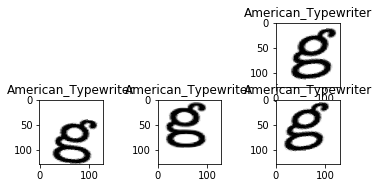

In [78]:
# test and visualize data to check if there's some problem
print(X_train.shape, y_train.shape, y_train[0])
# for n in range(0, 1):
#     for i in range(0, len(X_train[n])):
#         print(X_train[n][i])
testTrain = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])        
for i in range(5, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(testTrain[i], cmap=plt.get_cmap('gray'))
    plt.title(labels_data[i])        

In [ ]:
model = my_deeper_cnn_model()
model.summary()
#Fit keras Model
# model.fit(X_train, Y_train,
#           batch_size=256, epochs=30, verbose=1, callbacks=callbacks,validation_data=(X_test,Y_test)) #instead of 15epoch
model.fit(X_train, y_train,
          batch_size=256, epochs=20, verbose=1)#, validation_split=0.0001) #instead of 15epoch
# callbacks=callbacks,
# Epoch 1/10
# 7744/60000 [==>...........................] - ETA: 96s - loss: 0.5806 - acc: 0.8164

# score = model.evaluate(X_test, Y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print('debuging')

['h1-Baskerville-003.jpeg', 'h1-Baskerville-004.jpeg', 'h1-Baskerville-005.jpeg', 'h1-Hobo_std-003.png', 'h1-Palatino-001.png', 'p-Andale_Mono-001.png', 'p-Andale_Mono-002.png', 'p-Baskerville-001.png', 'p-Baskerville-002.png', 'p-Cochin-001.png', 'p-Cochin-002.png', 'p-Helvetica-001.png', 'p-Helvetica-002.png', 'p-Hobo_std-001.png', 'p-Hobo_std-002.png']
(15, 129, 129)
Train shape: (15, 129, 129)
15 train samples
(15, 129, 129, 1)
(15, 129, 129, 1) (15,)


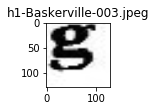

In [21]:
X_test, y_test = load_train('testImages')
X_test = process_income_image(X_test)
# imgTest = X_test.reshape(X_test.shape[0], imgSize[0], imgSize[1]，1)
print(X_test.shape, y_test.shape)

In [ ]:
# rst = model_L.predict_classes(images_datats, verbose=0)
# print(rst.shape)

print(X_train.shape, y_train.shape)
rst = model.predict_classes(X_train, verbose=1)
rststr = encoder.inverse_transform(rst)
print(rst)
print(rststr)
print(y_train, y_train.shape[0])
# print(y_test, y_test.shape[0])

rst_df = pd.DataFrame({"ImageId": list(range(1,len(rst)+1)),
                         "Label": rststr})#, "ytest": y_test.reshape(y_test.shape[0])})
rst_df.to_csv('predict_testing10.csv', index=False, header=True)


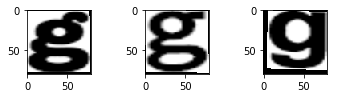

In [101]:
# for i in [27401,27402,27406,27511,27916,27992]:#range(10, 12):
#     i = 27992
#     plt.subplot(330 + i%3+1)#(i+1))
#     plt.imshow(imgTrain2[i], cmap=plt.get_cmap('gray'))
#     plt.title(rst[i])

for i in range(0, 3):
    plt.subplot(330 + (i+1))
    plt.imshow(sptImages[i], cmap=plt.get_cmap('gray'))
    # plt.title([i])

In [ ]:
from keras.models import load_model

model.save('my_model.h5')

# model_L = load_model('my_model.h5')
# model_L.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# score = model_L.evaluate(X_test, Y_test, verbose=0)
# print("%s: %.2f%%" % (model_L.metrics_names[1], score[1]*100))